In [2]:
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import roc_auc_score, brier_score_loss, roc_curve
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# 1. 讀 external 資料
df_ext = pd.read_parquet('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/EDA_Ext_Val.parquet', engine='pyarrow')

# 你 final model 用的 features（4 或 5 個，看你最後版本）
features = ['AJCC_Substage', 'PNI', 'LNR', 'Differentiation']

# 確保 target 存在
cols_needed = features + ['edr_18m']
df_ext_clean = df_ext[cols_needed].copy()

# 只留有 label 的 case
df_ext_clean = df_ext_clean.dropna(subset=['edr_18m']).copy()

X_ext_raw = df_ext_clean[features].copy()
y_ext = df_ext_clean['edr_18m'].astype(int)

print(f"External N = {len(X_ext_raw)}, events = {y_ext.sum()}")

External N = 144, events = 23


In [3]:
# 2-1. 把 PNI / Differentiation 轉成數值
X_ext_raw['PNI'] = pd.to_numeric(X_ext_raw['PNI'], errors='coerce')
X_ext_raw['Differentiation'] = pd.to_numeric(X_ext_raw['Differentiation'], errors='coerce')

# 2-2. One-Hot Encoding AJCC_Substage（跟 training 一樣：保留所有子期，不 drop_first）
X_ext_ohe = pd.get_dummies(X_ext_raw, columns=['AJCC_Substage'])

# 2-3. 把 inf 變 NaN
X_ext_ohe.replace([np.inf, -np.inf], np.nan, inplace=True)


In [4]:
# 3-1. 載入當初 training 用的欄位順序
feature_columns = joblib.load('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/final_feature_columns.pkl')

# 3-2. 確保 external 有所有這些欄位，沒有就補 0
for col in feature_columns:
    if col not in X_ext_ohe.columns:
        X_ext_ohe[col] = 0

# 3-3. 只保留這些欄位，並照同樣順序排
X_ext_ohe = X_ext_ohe[feature_columns]

In [6]:
# 4-1. 載入當初訓練好的 Imputer
imputer = joblib.load('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/final_knn_imputer.pkl')

# 4-2. 對 external 做 transform（不能再 fit！）
X_ext_imputed = pd.DataFrame(imputer.transform(X_ext_ohe),
                             columns=feature_columns)

/Users/huangshifeng/mlenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/huangshifeng/mlenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/huangshifeng/mlenv/lib/python3.11/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


In [7]:
# 5-1. 載入你存好的 final calibrated model
final_model = joblib.load('/Users/huangshifeng/Desktop/stage_III_colon_surv/data/final_model_calibrated.pkl')

# 5-2. 預測 external 的機率
y_ext_prob = final_model.predict_proba(X_ext_imputed)[:, 1]

# 5-3. 計算 external AUC & Brier score
auc_ext = roc_auc_score(y_ext, y_ext_prob)
brier_ext = brier_score_loss(y_ext, y_ext_prob)

print(f"External AUC = {auc_ext:.3f}")
print(f"External Brier score = {brier_ext:.3f}")


External AUC = 0.656
External Brier score = 0.135


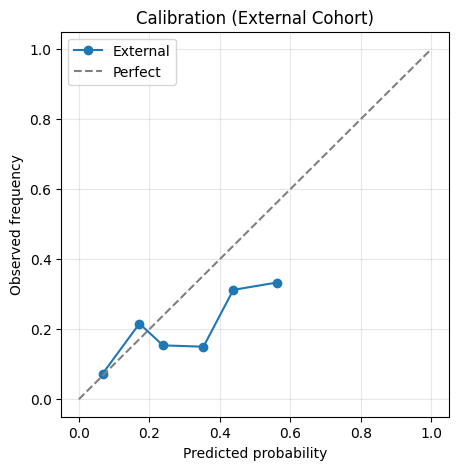

In [8]:
prob_true, prob_pred = calibration_curve(y_ext, y_ext_prob, n_bins=10)

plt.figure(figsize=(5,5))
plt.plot(prob_pred, prob_true, marker='o', label='External')
plt.plot([0,1], [0,1], '--', color='gray', label='Perfect')
plt.xlabel('Predicted probability')
plt.ylabel('Observed frequency')
plt.title('Calibration (External Cohort)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()